## **PREDICTING CONVERSION RATES** - Think Green Supplies

Think Green Supplies, sells various merchandise to businesses & consumers via one sales channel, our ecommerce store (website). Using obfuscated Google Analytics data on each visitor session, you will build a model that predicts whether each session will result in the visitor performing an action to add an item to the cart.

Goal: To predict for each visitor session, whether it will result in addedToCart (1) or not (0).

**DATA SCHEMA**

• fullVisitorId: The unique visitor ID. 

• visitStartTime: The timestamp (expressed as POSIX time). 

• date: The date of the session. 

• deviceCategory: The type of device (Mobile, Tablet, Desktop). 

• isMobile: If the user is on a mobile device, this value is true, otherwise false. 

• operatingSystem: The operating system of the device (e.g., "Macintosh" or "Windows"). 

• browser: The browser used (e.g., "Chrome" or "Firefox"). 

• country: The country from which sessions originated, based on IP address. 

• city: Users' city, derived from their IP addresses or Geographical IDs

• trafficSource: The source of the traffic source. Could be the name of the search engine, the referring hostname, or a value of the utm_source URL parameter. 

• trafficMedium: The medium of the traffic source. Could be "organic", "cpc", "referral", or the value of the utm_medium URL parameter. 

• trafficCampaign: The campaign value. Usually set by the utm_campaign URL parameter. 

• isFirstVisit: 1 if this is the first visit made by the visitor, otherwise 0. 

• isBounce: 1 if the visitor went to only one webpage and did not come back, otherwise 0. 

• totalVisits: The total number of visits by the visitor across sessions. 

• totalHits: The total number of interactions across sessions. 

• totalPageviews: The total number of page views across sessions. 

• totalTimeOnSite: The total time on site. 

• totalTransactions: The total number of interactions across sessions. 

• productPagesViewed: The number of product pages viewed in the session. 

• addedToCart: If the visitor added an item to the cart or made further downstream actions (checkout, transaction), otherwise 0 (if the visitor only browsed but never added an item to the cart).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


# Reading the datasets

In [ ]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


train_data = pd.read_csv('greensupplies_training_data.csv')
test_data = pd.read_csv('greensupplies_test_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train_data

,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart
0,4214259466202417480,1476492957,2016-10-14 00:00:00 UTC,desktop,False,Windows,Internet Explorer,United States,not available in demo dataset,ask,organic,(not set),0,1,2,2,16,0,0
1,3541738396641160713,1493611205,2017-04-30 00:00:00 UTC,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),0,1,1,1,0,0,0
2,8276557623242379934,1490071147,2017-03-20 00:00:00 UTC,desktop,False,Windows,Chrome,Australia,Brisbane,ask,organic,(not set),0,1,2,2,16,0,0
3,5855313117666192014,1491048053,2017-04-01 00:00:00 UTC,desktop,False,Windows,Chrome,Australia,Sydney,ask,organic,(not set),0,1,1,1,0,0,0
4,2619633492044211273,1495292376,2017-05-20 00:00:00 UTC,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),0,1,15,12,326,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765702,112313025021493147,1477626950,2016-10-27 00:00:00 UTC,desktop,False,Windows,Chrome,United States,not available in demo dataset,uweoconnect.extn.washington.edu,referral,(not set),1,1,1,1,0,0,0
765703,5128790713477036814,1476843645,2016-10-18 00:00:00 UTC,desktop,False,Macintosh,Chrome,United States,Seattle,uweoconnect.extn.washington.edu,referral,(not set),1,1,1,1,0,0,0
765704,4958625381188085654,1481077912,2016-12-06 00:00:00 UTC,desktop,False,Windows,Chrome,United States,Seattle,uweoconnect.extn.washington.edu,referral,(not set),1,1,1,1,0,0,0
765705,5202168656086679244,1476843631,2016-10-18 00:00:00 UTC,desktop,False,Macintosh,Chrome,United States,San Francisco,uweoconnect.extn.washington.edu,referral,(not set),1,1,2,2,438,0,0


In [ ]:
test_data.head()

,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed
0,788269418281542126,1496681584,2017-06-05 00:00:00 UTC,tablet,True,iOS,Chrome,United States,Mountain View,ask,organic,(not set),1,1,4,3,85,1
1,4029010814852735558,1500581209,2017-07-20 00:00:00 UTC,mobile,True,iOS,Safari,Netherlands,not available in demo dataset,ask,organic,(not set),1,1,1,1,0,0
2,1290376851612846048,1500783647,2017-07-22 00:00:00 UTC,mobile,True,iOS,Safari,United States,San Francisco,dfa,cpm,(not set),0,1,1,1,0,0
3,5426533588897404514,1496444163,2017-06-02 00:00:00 UTC,mobile,True,iOS,Safari,United States,Houston,dfa,cpm,(not set),0,1,2,2,9,0
4,2372356979576453844,1501119781,2017-07-26 00:00:00 UTC,mobile,True,iOS,Safari,United States,not available in demo dataset,dfa,cpm,(not set),0,1,10,10,251,0


In [ ]:
# Numerical features summary statistics

train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
visitStartTime,765707.0,1.482476e+09,7.325498e+06,1.470035e+09,1.476733e+09,1.481222e+09,1.488812e+09,1.496300e+09
isFirstVisit,765707.0,7.812962e-01,4.133674e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totalVisits,765707.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totalHits,765707.0,4.625048e+00,9.840340e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totalPageviews,765707.0,3.870623e+00,7.175096e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.690000e+02
totalTimeOnSite,765707.0,1.294440e+02,3.648859e+02,0.000000e+00,0.000000e+00,2.000000e+00,8.200000e+01,1.901700e+04
productPagesViewed,765707.0,4.056591e-01,1.759452e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.680000e+02
addedToCart,765707.0,5.429361e-02,2.265963e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
# Non numerical features summary statistics

train_data[['deviceCategory', 'isMobile', 'operatingSystem', 'browser', 'country', 'city', 'trafficSource', 'trafficMedium']].describe().T 

,count,unique,top,freq
deviceCategory,765707,3,desktop,575126
isMobile,765707,2,False,575176
operatingSystem,765707,20,Windows,302872
browser,765707,50,Chrome,522729
country,765707,218,United States,300429
city,765707,618,not available in demo dataset,431385
trafficSource,765707,258,(direct),311921
trafficMedium,765707,7,(none),311920


# Feature selection for non numerical and numerical data and data analysis

For the non numerical data columns the operating system, and browser data are removed from the analysis because purchases will be made regardless of the information. The city information has the majority of it information missing and would not contribute to the analysis as well. The trafficSource data needs more source information and can be replaced by the trafficMedium data. The deviceCategory data also includes information from the isMobile column.   

In [ ]:
train_data.duplicated().sum()

0

In [ ]:
test_data.duplicated().sum()

0

In [ ]:
train_data.dropna(inplace=True)

In [ ]:
test_data.dropna(inplace=True)

In [ ]:
train_data.groupby(by='country').sum().sort_values(by='addedToCart', ascending=False)[:10]

,visitStartTime,isMobile,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart
country,,,,,,,,,
United States,445533511538284,86312,198281,300429,2110805,1722844,58035698,207173,28057
Canada,31612831437807,6139,15568,21314,135293,111459,3955380,12370,1995
India,62069895532280,13170,37147,41847,125076,106972,3762267,10511,1593
United Kingdom,44821991940627,11327,25337,30207,88360,77285,2377980,5858,821
Japan,24239284227537,4051,13268,16341,62766,53286,1874240,5026,523
Australia,15122017877418,3385,8636,10194,41040,34045,1154923,3871,503
France,19770024205304,3452,10558,13323,45558,39407,1483972,3493,496
Germany,24919418918827,5941,14280,16795,52643,45927,1437649,3685,495
Netherlands,14428949331567,2851,7959,9723,31446,27199,940672,2130,360


Of all of the countries that made purchases from the site the United States tops the list with other countries in Europe as well as India, Australia and Taiwan. It is noteworthy that India is an important country for first time visitors, mobile device users and total number of products viewed as a country in the top 3 for total purchases.

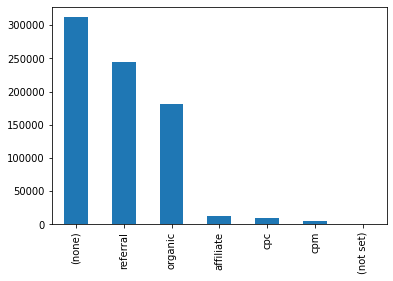

In [ ]:
train_data['trafficMedium'].value_counts().plot(kind='bar')

In [ ]:
train_data[train_data['addedToCart']==0]['trafficMedium'].value_counts()

(none)       286030
referral     241943
organic      169835
affiliate     12579
cpc            8875
cpm            4760
(not set)       112
Name: trafficMedium, dtype: int64

In [ ]:
train_data[train_data['addedToCart']==1]['trafficMedium'].value_counts()

(none)       25890
organic      11171
referral      2636
cpc            770
affiliate      671
cpm            431
(not set)        4
Name: trafficMedium, dtype: int64

From the plots and value counts the trafficMedium does affect the volume of purchases made in the website. For instance organic traffic performs better purchases compared to non purchases and referrals do not perform as well for purchases compared to purchases. Buyers that went to the site on their own peharps by means of search engine (Google) make up the most purchases. Further clarification about none and non-set categories to know what they are. The trafficMedium will be converted into a dummy variable. Whether a mobile phone is used or not on the site has little or no effect on purchases from the website data. 

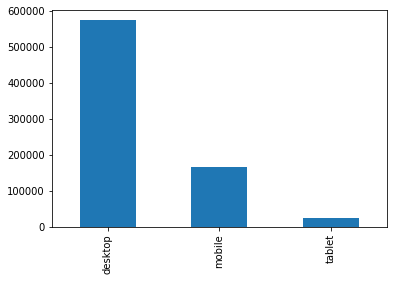

In [ ]:
train_data['deviceCategory'].value_counts().plot(kind='bar')

In [ ]:
train_data[train_data['addedToCart']==0]['deviceCategory'].value_counts()

desktop    541250
mobile     159272
tablet      23612
Name: deviceCategory, dtype: int64

In [ ]:
train_data[train_data['addedToCart']==1]['deviceCategory'].value_counts()

desktop    33876
mobile      6676
tablet      1021
Name: deviceCategory, dtype: int64

Since purchases and non purchases have the same rankings for the 3 device categories customers decision to make a purchase regardless of the device they use. The majority of visitors to the site are desktop users followed by mobile phone users and then tablet users. The only categorical variable that will be used for the data modeling process is the trafficMedium variable.

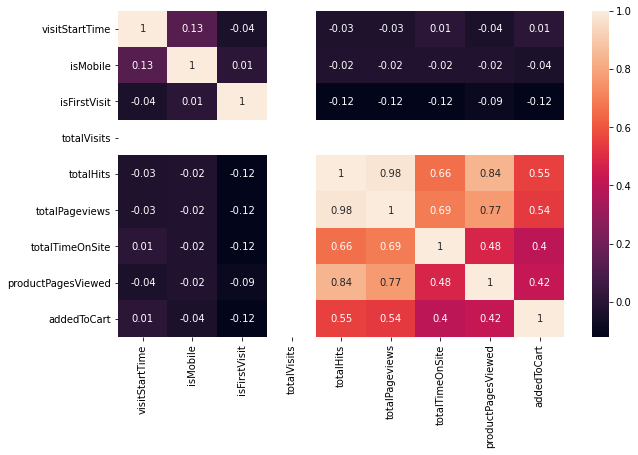

In [ ]:
# Correlation plot for numerical variables

plt.figure(figsize=(10,6))
correlation_matrix = train_data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


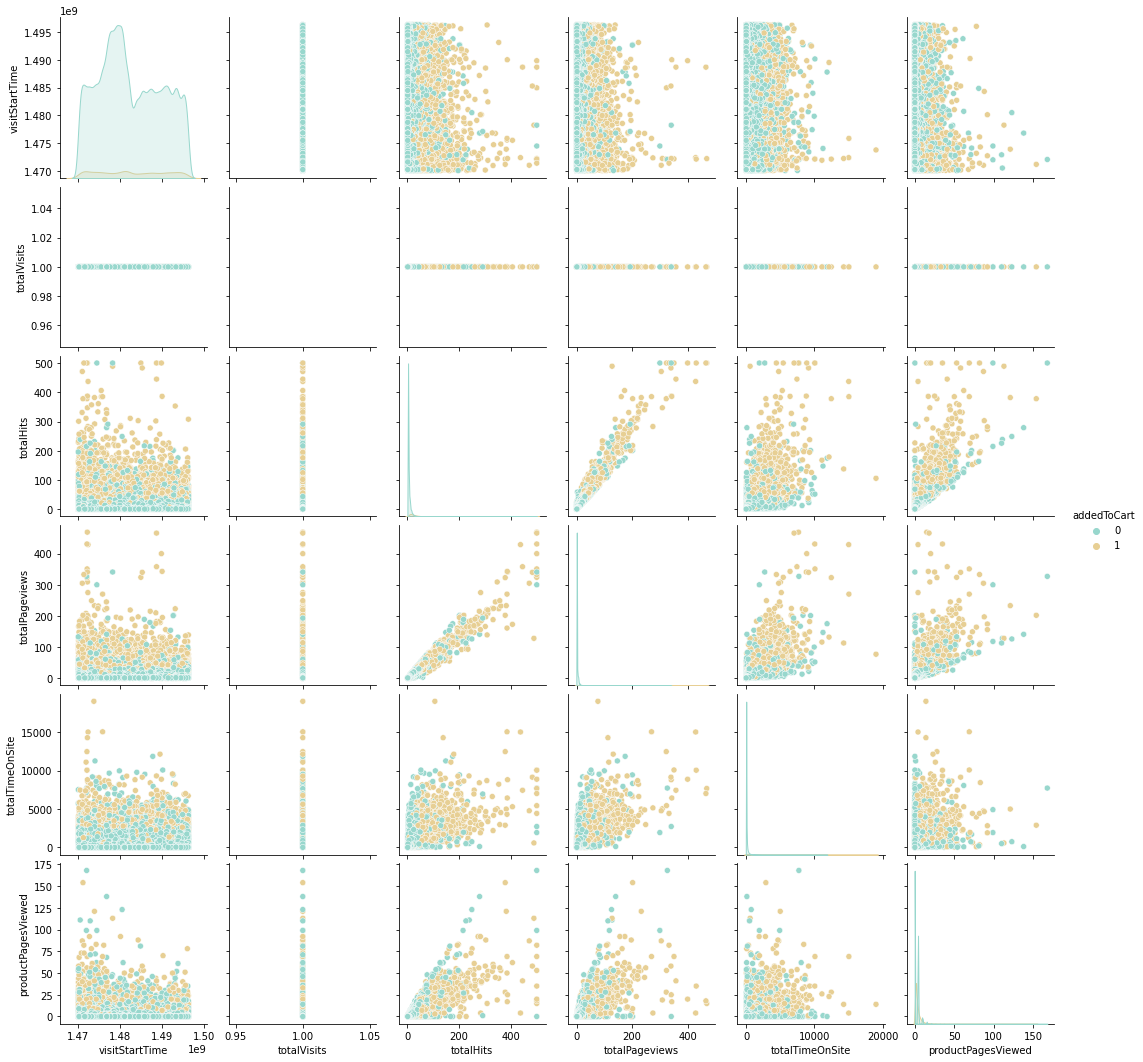

In [ ]:
sns.pairplot(vars=['visitStartTime', 'totalVisits', 'totalHits', 'totalPageviews', 'totalTimeOnSite', 'productPagesViewed'], data=train_data, hue= 'addedToCart', palette='BrBG_r')
plt.show()

From the correlation matrix and pairplots either totalHits or totalPageviews should be dropped since they are related.

In [ ]:
print('Ratio of 0s to 1s ', int(train_data['addedToCart'].value_counts(ascending=True)[0] / train_data['addedToCart'].value_counts(ascending=True)[1]),':',1)

Ratio of 0s to 1s  17 : 1


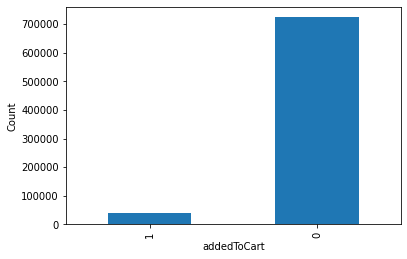

In [ ]:
plt.xlabel('addedToCart')
plt.ylabel('Count')
train_data['addedToCart'].value_counts(ascending=True).plot(kind='bar')

The truth value of the addedToCart variable (1) has the minority sample for the variable. The dataset should have a representative sample for data modeling. This can be done by resampling taking a minority from the false value (0) and a majority sample from the truth value or undersampling the majority class. A SMTOE technique can be applied.

In SMOTE (Synthetic Minority Oversampling Technique) we synthesize elements for the minority class, in the vicinity of already existing elements. This can also be taken care of during the model development process.

# Data preparation

In [ ]:
# Picking the relevant columns

train_data.columns

Index(['fullVisitorId', 'visitStartTime', 'date', 'deviceCategory', 'isMobile',
       'operatingSystem', 'browser', 'country', 'city', 'trafficSource',
       'trafficMedium', 'trafficCampaign', 'isFirstVisit', 'totalVisits',
       'totalHits', 'totalPageviews', 'totalTimeOnSite', 'productPagesViewed',
       'addedToCart'],
      dtype='object')

In [ ]:
columns = ['fullVisitorId','trafficMedium', 'isFirstVisit', 'totalVisits',
           'totalPageviews', 'totalTimeOnSite', 'productPagesViewed', 'addedToCart']

In [ ]:
df_train = train_data[columns]
df_train.index = df_train['fullVisitorId']
df_train.drop(labels='fullVisitorId', axis=1, inplace=True)

In [ ]:
test_data.columns

Index(['fullVisitorId', 'visitStartTime', 'date', 'deviceCategory', 'isMobile',
       'operatingSystem', 'browser', 'country', 'city', 'trafficSource',
       'trafficMedium', 'trafficCampaign', 'isFirstVisit', 'totalVisits',
       'totalHits', 'totalPageviews', 'totalTimeOnSite', 'productPagesViewed'],
      dtype='object')

In [ ]:
df_test = test_data[['fullVisitorId','trafficMedium', 'isFirstVisit', 'totalVisits',
                    'totalPageviews', 'totalTimeOnSite', 'productPagesViewed']]
df_test.index = df_test['fullVisitorId']
df_test.drop(labels='fullVisitorId', axis=1, inplace=True)

In [ ]:
df_train.head()

,trafficMedium,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart
fullVisitorId,,,,,,,
4214259466202417480,organic,0,1,2,16,0,0
3541738396641160713,organic,0,1,1,0,0,0
8276557623242379934,organic,0,1,2,16,0,0
5855313117666192014,organic,0,1,1,0,0,0
2619633492044211273,organic,0,1,12,326,1,1


In [ ]:
df_test.head()

,trafficMedium,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed
fullVisitorId,,,,,,
788269418281542126,organic,1,1,3,85,1
4029010814852735558,organic,1,1,1,0,0
1290376851612846048,cpm,0,1,1,0,0
5426533588897404514,cpm,0,1,2,9,0
2372356979576453844,cpm,0,1,10,251,0


Undersampling the majority class not added to the cart (0) reshuffling the combined dataset and training the models give less biased results. 

In [ ]:
train_data['addedToCart'].value_counts(ascending=True)

1     41573
0    724134
Name: addedToCart, dtype: int64

In [ ]:
df_no_cart = train_data[train_data['addedToCart']==0][:41573]
df_cart = train_data[train_data['addedToCart']==1]
df_combined = pd.concat([df_no_cart, df_cart])

In [ ]:
df_combined.head()

,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,isFirstVisit,totalVisits,totalHits,totalPageviews,totalTimeOnSite,productPagesViewed,addedToCart
0,4214259466202417480,1476492957,2016-10-14 00:00:00 UTC,desktop,False,Windows,Internet Explorer,United States,not available in demo dataset,ask,organic,(not set),0,1,2,2,16,0,0
1,3541738396641160713,1493611205,2017-04-30 00:00:00 UTC,desktop,False,Windows,Chrome,United States,not available in demo dataset,ask,organic,(not set),0,1,1,1,0,0,0
2,8276557623242379934,1490071147,2017-03-20 00:00:00 UTC,desktop,False,Windows,Chrome,Australia,Brisbane,ask,organic,(not set),0,1,2,2,16,0,0
3,5855313117666192014,1491048053,2017-04-01 00:00:00 UTC,desktop,False,Windows,Chrome,Australia,Sydney,ask,organic,(not set),0,1,1,1,0,0,0
5,2735112617112103081,1494792010,2017-05-14 00:00:00 UTC,desktop,False,Windows,Chrome,Italy,not available in demo dataset,ask,organic,(not set),0,1,1,1,0,0,0


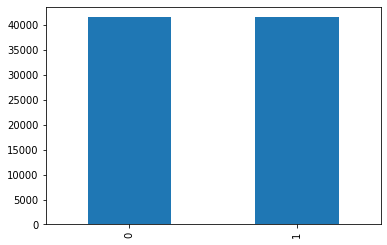

In [ ]:
df_combined['addedToCart'].value_counts(ascending=True).plot(kind='bar')

In [ ]:
# Suffling and setting the dependent and target variables

df_combined = df_combined.sample(frac=1, random_state=42)

x_train = df_combined[columns[:-1]]
y_train = df_combined['addedToCart']

In [ ]:
# Turning the trafficMedium variable into numerical categories

x_train = pd.get_dummies(data=x_train, columns=['trafficMedium'])

In [ ]:
x_train.set_index(keys='fullVisitorId', inplace=True)
x_train

,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed,trafficMedium_(none),trafficMedium_(not set),trafficMedium_affiliate,trafficMedium_cpc,trafficMedium_cpm,trafficMedium_organic,trafficMedium_referral
fullVisitorId,,,,,,,,,,,,
6044278422205391612,0,1,1,0,0,0,0,0,0,0,1,0
1821134574839324136,1,1,7,189,1,1,0,0,0,0,0,0
7043818383887881308,0,1,1,0,0,0,0,0,0,0,1,0
1054368481850016599,0,1,11,341,1,0,0,0,1,0,0,0
1237292253899580363,0,1,3,31,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7627718815783146338,0,1,16,497,3,0,0,0,0,0,1,0
9865893747933434812,0,1,14,928,1,1,0,0,0,0,0,0
8323494343033295711,1,1,17,712,1,1,0,0,0,0,0,0


In [ ]:
# Splitting the data into training and testing for modeling

index = int(len(x_train)*0.80)
# print(index)

train_X_ress = x_train[:index]
test_X_ress = x_train[index:]

train_Y_ress = y_train[:index]
test_Y_ress = y_train[index:]

In [ ]:
# Scaling the dataset to be between 0 and 1 


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
fit = scaler.fit(train_X_ress)
train_X_trans = fit.transform(train_X_ress)
test_X_trans = fit.transform(test_X_ress)

# Model Building

In [ ]:
# Trying a logistic regression fit on the dataset

from sklearn.linear_model import LogisticRegression

In [ ]:
# Performing a grid search for the best parameters for Logistic regression

from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {
    'C': np.linspace(1, 10, 10),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty' : ['l1', 'l2'],
              }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(train_X_trans, train_Y_ress.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.9s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   13.5s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   44.1s
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=3,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sco

In [ ]:
clf.best_estimator_

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’

penalty = 'l1'
solver = 'liblinear'
# class_weight = 'balanced' #{0:1, 1:80}  
max_iter = 100
C = 2.0
# random_state = 1
log_reg = LogisticRegression(solver = solver, penalty=penalty, max_iter=max_iter, C=C)

In [ ]:
fit = log_reg.fit(train_X_trans, train_Y_ress)

In [ ]:
# Measuring classification accuracy

from sklearn.metrics import accuracy_score

train_X_pred = fit.predict(train_X_trans)
test_X_pred = fit.predict(test_X_trans)

print('Training accuracy:{0:.2f}'.format(accuracy_score(train_Y_ress, train_X_pred)))
print('Validation accuracy:{0:.2f}'.format(accuracy_score(test_Y_ress, test_X_pred)))

Training accuracy:0.96
Validation accuracy:0.96


In [ ]:
# Evaluation metrics for Logistic regression including precision, recall, f1-score, roc accuraccy score

from sklearn.metrics import classification_report

report = classification_report(test_Y_ress, test_X_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      8393
           1       0.98      0.93      0.95      8237

    accuracy                           0.96     16630
   macro avg       0.96      0.96      0.96     16630
weighted avg       0.96      0.96      0.96     16630



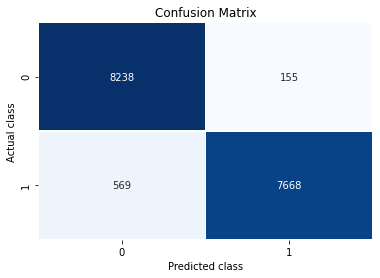

In [ ]:
# confusion matrix plot 

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,4))

cm = confusion_matrix(test_Y_ress, test_X_pred)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion Matrix");

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
print('Logistic Regression: ', roc_auc_score(train_Y_ress, train_X_pred).round(2))

Logistic Regression:  0.96


In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(test_Y_ress, test_X_pred)

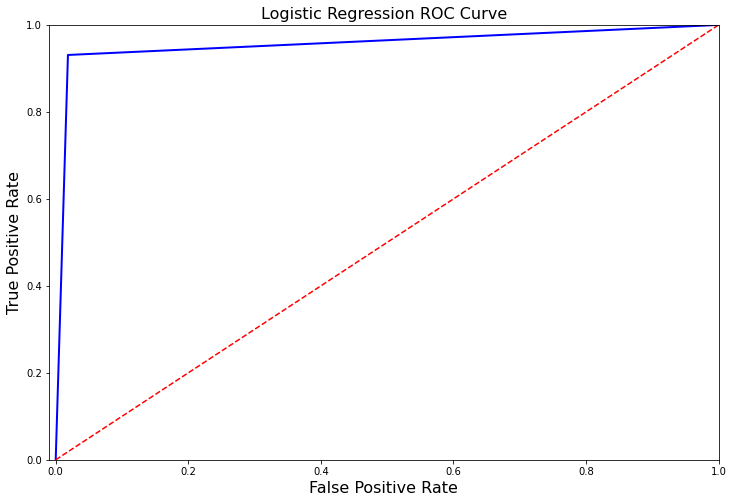

In [ ]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [ ]:
# Trying other ML algorithm classifiers to compare training results

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Finding the best estimators using grid search for each classifier

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(train_X_trans, train_Y_ress.ravel())
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(train_X_trans, train_Y_ress.ravel())

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(train_X_trans, train_Y_ress.ravel())

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [ ]:
# Prediction results for the other classifiers using test data

from sklearn.model_selection import cross_val_predict

knears_pred = cross_val_predict(knears_neighbors, train_X_trans, train_Y_ress, cv=5)

svc_pred = cross_val_predict(svc, train_X_trans, train_Y_ress, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, train_X_trans, train_Y_ress, cv=5)

In [ ]:
# Roc accuraccy scores for the other ML classifiers

from sklearn.metrics import roc_auc_score
print('KNears Neighbors: ', roc_auc_score(train_Y_ress, knears_pred).round(2))
print('Support Vector Classifier: ', roc_auc_score(train_Y_ress, svc_pred).round(2))
print('Decision Tree Classifier: ', roc_auc_score(train_Y_ress, tree_pred).round(2))

KNears Neighbors:  0.95
Support Vector Classifier:  0.99
Decision Tree Classifier:  0.93


In [ ]:
# Test data prediction for SVM

svm_pred = svc.predict(test_X_trans)

In [ ]:
# Evaluation metrics for Logistic regression including precision, recall, f1-score, roc accuraccy score

from sklearn.metrics import classification_report

report = classification_report(test_Y_ress, svm_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      8393
           1       0.99      0.92      0.95      8237

    accuracy                           0.95     16630
   macro avg       0.96      0.95      0.95     16630
weighted avg       0.95      0.95      0.95     16630



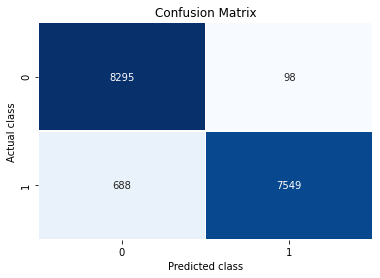

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(6,4))

cm = confusion_matrix(test_Y_ress, svm_pred)
sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion Matrix");

In [ ]:
svc_fpr, svc_tpr, svc_thresold = roc_curve(test_Y_ress, svm_pred)

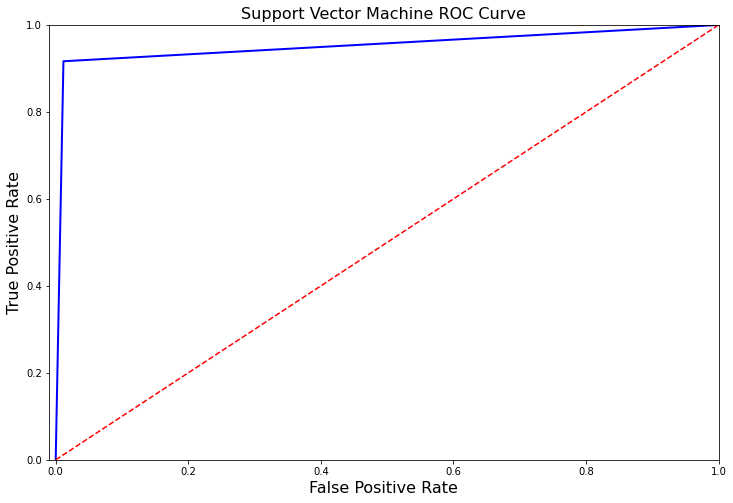

In [ ]:
def svc_roc_curve(svc_fpr, svc_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Support Vector Machine ROC Curve', fontsize=16)
    plt.plot(svc_fpr, svc_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

svc_roc_curve(svc_fpr, svc_tpr)
plt.show()

Based on the AUC score results and the classification reports the best Machine learning classifier for the data is Support Vector Machine classifier 

# Making predictions on the final testing data

In [ ]:
df_test

,trafficMedium,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed
fullVisitorId,,,,,,
788269418281542126,organic,1,1,3,85,1
4029010814852735558,organic,1,1,1,0,0
1290376851612846048,cpm,0,1,1,0,0
5426533588897404514,cpm,0,1,2,9,0
2372356979576453844,cpm,0,1,10,251,0
...,...,...,...,...,...,...
8048886714743827258,(none),1,1,1,0,0
6153501905266331081,(none),0,1,1,0,0
9769058468255015745,(none),1,1,3,75,2


In [ ]:
df_test = pd.get_dummies(data=df_test, columns=['trafficMedium'])
df_test

,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed,trafficMedium_(none),trafficMedium_(not set),trafficMedium_affiliate,trafficMedium_cpc,trafficMedium_cpm,trafficMedium_organic,trafficMedium_referral
fullVisitorId,,,,,,,,,,,,
788269418281542126,1,1,3,85,1,0,0,0,0,0,1,0
4029010814852735558,1,1,1,0,0,0,0,0,0,0,1,0
1290376851612846048,0,1,1,0,0,0,0,0,0,1,0,0
5426533588897404514,0,1,2,9,0,0,0,0,0,1,0,0
2372356979576453844,0,1,10,251,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8048886714743827258,1,1,1,0,0,1,0,0,0,0,0,0
6153501905266331081,0,1,1,0,0,1,0,0,0,0,0,0
9769058468255015745,1,1,3,75,2,1,0,0,0,0,0,0


In [ ]:
df_test = df_test.sample(frac=1, random_state=42)
df_test

,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed,trafficMedium_(none),trafficMedium_(not set),trafficMedium_affiliate,trafficMedium_cpc,trafficMedium_cpm,trafficMedium_organic,trafficMedium_referral
fullVisitorId,,,,,,,,,,,,
544832398751618920,0,1,1,0,0,1,0,0,0,0,0,0
8880704751501785711,1,1,1,0,0,0,0,0,0,0,1,0
375802158827085958,1,1,5,55,0,1,0,0,0,0,0,0
4848925389261824691,1,1,1,0,0,0,0,0,0,0,1,0
8847154039606347929,1,1,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3039951433561491933,1,1,3,125,0,0,0,0,0,0,1,0
1451254335795424761,1,1,3,119,0,1,0,0,0,0,0,0
5125140299363465569,0,1,6,30,0,1,0,0,0,0,0,0


In [ ]:
fit = scaler.fit(df_test)
test_X = fit.transform(df_test)

In [ ]:
test_pred = svc.predict(test_X)

In [ ]:
pd.Series(test_pred).value_counts()

1    127148
0     10798
dtype: int64

In [ ]:
df_test['addedToCart'] = test_pred
df_test

,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed,trafficMedium_(none),trafficMedium_(not set),trafficMedium_affiliate,trafficMedium_cpc,trafficMedium_cpm,trafficMedium_organic,trafficMedium_referral,addedToCart
fullVisitorId,,,,,,,,,,,,,
544832398751618920,0,1,1,0,0,1,0,0,0,0,0,0,1
8880704751501785711,1,1,1,0,0,0,0,0,0,0,1,0,1
375802158827085958,1,1,5,55,0,1,0,0,0,0,0,0,1
4848925389261824691,1,1,1,0,0,0,0,0,0,0,1,0,1
8847154039606347929,1,1,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039951433561491933,1,1,3,125,0,0,0,0,0,0,1,0,1
1451254335795424761,1,1,3,119,0,1,0,0,0,0,0,0,1
5125140299363465569,0,1,6,30,0,1,0,0,0,0,0,0,1


In [ ]:
df_test.reset_index(inplace=True)
df_test

,fullVisitorId,isFirstVisit,totalVisits,totalPageviews,totalTimeOnSite,productPagesViewed,trafficMedium_(none),trafficMedium_(not set),trafficMedium_affiliate,trafficMedium_cpc,trafficMedium_cpm,trafficMedium_organic,trafficMedium_referral,addedToCart
0,544832398751618920,0,1,1,0,0,1,0,0,0,0,0,0,1
1,8880704751501785711,1,1,1,0,0,0,0,0,0,0,1,0,1
2,375802158827085958,1,1,5,55,0,1,0,0,0,0,0,0,1
3,4848925389261824691,1,1,1,0,0,0,0,0,0,0,1,0,1
4,8847154039606347929,1,1,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137941,3039951433561491933,1,1,3,125,0,0,0,0,0,0,1,0,1
137942,1451254335795424761,1,1,3,119,0,1,0,0,0,0,0,0,1
137943,5125140299363465569,0,1,6,30,0,1,0,0,0,0,0,0,1
137944,5356901769430312331,1,1,2,296,0,1,0,0,0,0,0,0,1


In [ ]:
df_predictions = df_test[['fullVisitorId', 'addedToCart']]
df_predictions

,fullVisitorId,addedToCart
0,544832398751618920,1
1,8880704751501785711,1
2,375802158827085958,1
3,4848925389261824691,1
4,8847154039606347929,1
...,...,...
137941,3039951433561491933,1
137942,1451254335795424761,1
137943,5125140299363465569,1
137944,5356901769430312331,1


In [ ]:
df_predictions.to_csv('predictions.csv')